In [68]:
import FCA, pickle, csv
import numpy as np
import pandas as pd
import networkx as nx
import statistics as s
from math import floor
from NNetwork import NNetwork as nn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings("ignore")

from sklearn.manifold import SpectralEmbedding

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
sampler = RandomUnderSampler()

from karateclub import Node2Vec
from karateclub import Graph2Vec


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as rf

In [ ]:
def model_metrics(model, y_test, y_pred):
    conf_matrix = confusion_matrix(y_true = y_test, y_pred = y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                  display_labels=model.classes_)
    disp.plot()
    plt.show()
    
    print('Precision: %.3f' % precision_score(y_test, y_pred))
    print('Recall: %.3f' % recall_score(y_test, y_pred))
    print('F1: %.3f' % f1_score(y_test, y_pred))
    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
    
    pass
    return

In [4]:
# FCA_iter: total iteration for the FCA model, used for label
# baseline_iter: the iteration for baseline model, usually less than FCA_iter
# iter_include: number of iteration to include in the dataframe
# X: a list of graph structure (for each graph, length = k^2 if num_nodes=k)
# num_edges, num_nodes, min_degree, max_degree, diameter, quartile_1, quartile_2, quartile_3, states, y, baseline_width
def FCA_datagen(num_nodes, kappa, FCA_iter, baseline_iter, iter_include, file_name, X):
    # generate the toy dataset
    file = open(file_name, 'w+', newline='')

    header = ["num_edges", "num_nodes", "min_degree", "max_degree", "diameter", "quartile_1",
              "quartile_2", "quartile_3", "y", "baseline_width"]
    for i in range(baseline_iter):
        for j in range(num_nodes):
            header.append("s" + str(i + 1) + "_" + str(j + 1))

    with file:
        write = csv.writer(file)

        write.writerow(header)
        for i in range(X.shape[1]): #X.shape = (400, 3000)
            G=nx.from_pandas_adjacency(pd.DataFrame(X[:,i].reshape(20, -1)))
            G=nx.Graph(G)
            
            
            col = np.random.randint(0,kappa,size=num_nodes)

            num_edges = G.number_of_edges()
            min_degree = min(list(G.degree), key=lambda x: x[1])[1]
            max_degree = max(list(G.degree), key=lambda x: x[1])[1]
            diameter = nx.diameter(G)
            quartile_1 = s.quantiles(col, n=4)[0]
            quartile_2 = s.quantiles(col, n=4)[1]
            quartile_3 = s.quantiles(col, n=4)[2]

            sample = [num_edges, num_nodes, min_degree, max_degree, diameter,
                      quartile_1, quartile_2, quartile_3]
            states, label = FCA.FCA(G, col, kappa, FCA_iter)

            width = FCA.width_compute(states[FCA_iter - 1], kappa)
            y = False
            if (width < floor(kappa / 2)):  # half circle concentration
                y = True
            sample.append(y)

            baseline_width = FCA.width_compute(states[baseline_iter - 1], kappa)
            baseline = False
            if (baseline_width < floor(kappa / 2)):  # half circle concentration
                baseline = True
            sample.append(baseline)

            for j in range(iter_include):
                sample = sample + list(states[j])

            write.writerow(sample)
    #return graph_list

In [8]:
sampling_alg = 'pivot'

ntwk = 'Caltech36' # COVID_PPI, Wisconsin87, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'Subgraph_sampling/test1/'
k=20

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 769
num edges in G 33312


In [9]:
X, embs = G.get_patches(k=k, sample_size=10000, skip_folded_hom=True)
# file = open('toy.pkl', 'wb')
# pickle.dump(X, file)
# file.close()
X.shape

num of subgraphs induced on k-paths: 10000


(400, 10000)

In [10]:
num_nodes = 20
kappa = 10
FCA_iter = 200
baseline_iter = 50
iter_include = 5
file_name = "toy.csv"
FCA_datagen(num_nodes, kappa, FCA_iter, baseline_iter, iter_include, file_name, X)

In [18]:
df = pd.read_csv("toy.csv")
df

,num_edges,num_nodes,min_degree,max_degree,diameter,quartile_1,quartile_2,quartile_3,y,baseline_width,...,s5_11,s5_12,s5_13,s5_14,s5_15,s5_16,s5_17,s5_18,s5_19,s5_20
0,47,20,2,8,5,2.00,4.0,5.00,True,True,...,4,6,7,8,6,7,6,5,6,5
1,55,20,1,12,4,3.25,5.5,6.00,True,False,...,5,9,0,6,4,5,8,8,9,0
2,55,20,2,9,5,2.00,5.5,8.00,True,True,...,3,6,0,2,0,2,1,8,4,4
3,56,20,2,9,3,3.00,6.0,7.00,True,True,...,7,7,7,9,8,7,7,7,9,8
4,53,20,2,14,3,4.00,5.5,7.75,True,False,...,7,6,5,7,8,0,7,7,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,49,20,2,8,4,2.00,3.5,5.75,True,False,...,6,7,7,5,5,7,6,5,6,8
9996,42,20,2,7,5,1.00,3.5,5.75,True,True,...,5,8,4,1,7,6,8,8,7,7
9997,45,20,2,8,4,1.50,5.0,6.75,True,False,...,3,4,7,9,2,8,8,4,8,4
9998,49,20,2,9,4,4.25,6.0,8.00,True,False,...,2,9,5,3,0,9,8,6,6,8


In [19]:
df.y.value_counts()

True     9260
False     740
Name: y, dtype: int64

In [20]:
df.baseline_width.value_counts()

False    5280
True     4720
Name: baseline_width, dtype: int64

In [22]:
df.shape

(10000, 110)

In [26]:
X_adj = X.T
X_adj.shape

(10000, 400)

### The dimension of the projected subspace = 2

In [27]:
embedding = SpectralEmbedding(n_components=2)
X_transformed = embedding.fit_transform(X_adj)
X_transformed.shape

(10000, 2)

In [29]:
y = df.y.astype('int')


In [31]:
y.shape

(10000,)

In [34]:
X_resampled, y_resampled = sampler.fit_resample(X_transformed, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)

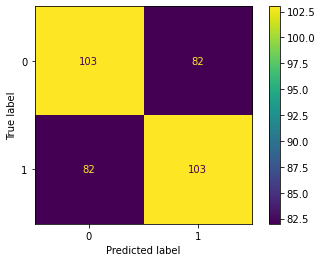

Precision: 0.557
Recall: 0.557
F1: 0.557
Accuracy: 0.557


In [38]:


clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

### The dimension of the projected subspace = 10

In [39]:
embedding = SpectralEmbedding(n_components=10)
X_transformed2 = embedding.fit_transform(X_adj)
X_transformed2.shape

(10000, 10)

In [40]:
X_resampled, y_resampled = sampler.fit_resample(X_transformed2, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)

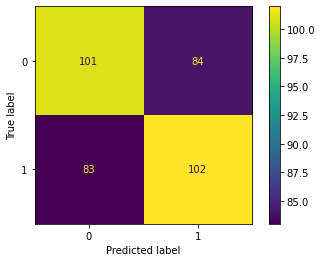

Precision: 0.548
Recall: 0.551
F1: 0.550
Accuracy: 0.549


In [41]:
clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

### The dimension of the projected subspace = 100

In [42]:
embedding = SpectralEmbedding(n_components=100)
X_transformed3 = embedding.fit_transform(X_adj)
X_transformed3.shape

(10000, 100)

In [47]:
X_resampled, y_resampled = sampler.fit_resample(X_transformed3, y)
    
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)

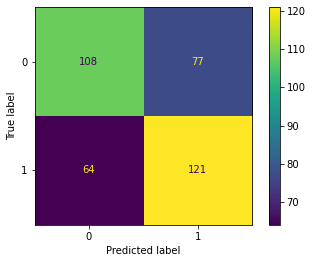

Precision: 0.611
Recall: 0.654
F1: 0.632
Accuracy: 0.619


In [48]:
clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

In [50]:
X.shape

(400, 10000)

### Check node2vec and graph2vec

In [62]:
X[:,i].reshape(20, -1) #adjacency matrix of the first sample
int(np.sqrt(X.shape[0]))

20

In [63]:
graph_list = []
for i in range(10000):
    G=nx.from_pandas_adjacency(pd.DataFrame(X[:,i].reshape(20, -1)))
    G=nx.Graph(G)
    graph_list.append(G)

In [64]:
len(graph_list)

10000

In [66]:
def n2v_embedding(graph_list):

    df_n2v = pd.DataFrame()

    for graph in graph_list:        
        n2v = Node2Vec(dimensions = 1)
        n2v.fit(graph)
        embed = n2v.get_embedding()
        df_embed = pd.DataFrame(embed.T)
        df_n2v = pd.concat([df_n2v, df_embed], ignore_index=True, axis=0)
        
    return df_n2v


In [67]:
df_n2v = n2v_embedding(graph_list)

KeyboardInterrupt: 

In [ ]:
df_n2v.shape

In [ ]:
X_resampled, y_resampled = sampler.fit_resample(df_n2v, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)


clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

In [76]:
g2v = Graph2Vec(wl_iterations = 5, dimensions = 10)
g2v.fit(graph_list)
embed = g2v.get_embedding()
df_g2v = pd.DataFrame(embed)

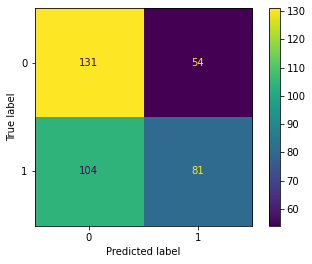

Precision: 0.600
Recall: 0.438
F1: 0.506
Accuracy: 0.573


In [82]:
X_resampled, y_resampled = sampler.fit_resample(df_g2v, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)


clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)

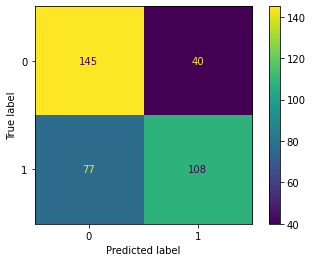

Precision: 0.730
Recall: 0.584
F1: 0.649
Accuracy: 0.684


In [84]:
X_resampled, y_resampled = sampler.fit_resample(X_adj, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                        test_size = 0.25,
                                                        stratify = y_resampled)


clf = rf(max_depth=5, max_features="log2")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
model_metrics(clf, y_test, y_pred)